In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor, nn
from torchvision.utils import make_grid


In [3]:
def save_samples(
    model: nn.Module,
    device: torch.device,
    filepath: str,
    num_samples: int = 64,
    latent_dim: int = 2,
    condition_dim: int = 10,
    use_conv: bool = False,
):
    model.eval()
    with torch.no_grad():
        # Create one-hot encoded conditions for each digit
        samples_per_digit = num_samples // 10
        conditions = []

        for digit in range(10):
            condition = torch.zeros(samples_per_digit, condition_dim)
            condition[:, digit] = 1.0
            conditions.append(condition)

        condition = torch.cat(conditions, dim=0).to(device)

        # Sample from latent space
        z = torch.randn(condition.size(0), latent_dim).to(device)

        # Generate samples
        samples = model.decode(z, condition)

        if not use_conv:
            samples = samples.view(-1, 1, 28, 28)

        # Save samples
        save_image(samples, filepath, nrow=10)
        print(f"Samples saved to {filepath}")


def save_image(tensor: Tensor, filepath: str, nrow: int = 8):  # noqa: ARG001
    grid = make_grid(tensor, nrow=nrow, padding=2, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))
    plt.axis("off")
    # plt.savefig(filepath, bbox_inches="tight")  # noqa: ERA001
    plt.show()
    plt.close()


In [ ]:
def visualize_latent_space(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        # Only visualize if latent space is 2D
        if model.latent_dim != 2:
            print(
                "Latent space visualization only supported for 2D latent space, "
                f"got {model.latent_dim}D"
            )
            return

        # Store encoded data points and their labels
        z_points = []
        labels = []

        for batch_idx, (data, condition, label) in enumerate(dataloader):
            # Limit to a reasonable number of points
            if batch_idx * data.size(0) >= 1000:
                break

            data, condition = data.to(device), condition.to(device)

            # Encode data
            mu, _ = model.encode(data, condition)

            # Store the points and labels
            z_points.append(mu.cpu().numpy())
            labels.append(label.numpy())

        # Concatenate all batches
        z_points = np.concatenate(z_points, axis=0)
        labels = np.concatenate(labels, axis=0)

        # Plot latent space
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(z_points[:, 0], z_points[:, 1], c=labels, cmap="tab10", alpha=0.6)
        plt.colorbar(scatter, label="Digit")
        plt.title("Latent Space Visualization")
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show()
        plt.close()


In [ ]:
def visualize_latent_space_3d(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        # Only visualize if latent space is 3D
        if model.latent_dim != 3:
            print(f"This 3D visualization only works for 3D latent space, got {model.latent_dim}D")
            return

        # Store encoded data points and their labels
        z_points = []
        labels = []

        for batch_idx, (data, condition, label) in enumerate(dataloader):
            # Limit to a reasonable number of points
            if batch_idx * data.size(0) >= 1000:
                break

            data, condition = data.to(device), condition.to(device)

            # Encode data
            mu, _ = model.encode(data, condition)

            # Store the points and labels
            z_points.append(mu.cpu().numpy())
            labels.append(label.numpy())

        # Concatenate all batches
        z_points = np.concatenate(z_points, axis=0)
        labels = np.concatenate(labels, axis=0)

        # Create 3D plot
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection="3d")

        # Create scatter plot
        scatter = ax.scatter(
            z_points[:, 0],
            z_points[:, 1],
            z_points[:, 2],
            c=labels,
            cmap="tab10",
            alpha=0.6,
            s=30,  # Point size
        )

        # Add colorbar and labels
        plt.colorbar(scatter, label="Digit")
        ax.set_title("3D Latent Space Visualization")
        ax.set_xlabel("z[0]")
        ax.set_ylabel("z[1]")
        ax.set_zlabel("z[2]")

        # Show plot
        plt.show()
        plt.close()

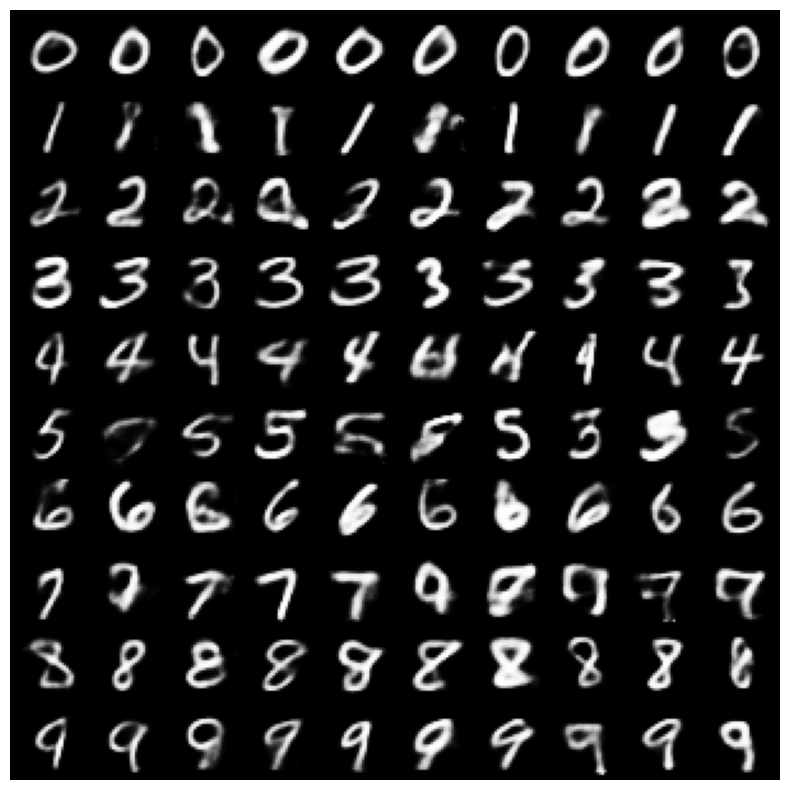

Samples saved to vae_samples.png


In [50]:
from src.models import BigConditionalVAE

latent = 20

model = BigConditionalVAE(
    input_dim=784,
    condition_dim=10,
    hidden_dim=512,
    latent_dim=latent,
)


checkpoint = torch.load(
    f"/v/raid1b/backup/hhisham/Courses/PDL/CS_6956_HW3/checkpoints/mnist_big_latent{latent}_hidden512.pt",
    map_location=torch.device("cuda"),
)

# Extract just the model state dict from the checkpoint
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# call the save_samples function
save_samples(
    model=model,
    device=device,
    filepath="vae_samples.png",
    num_samples=100,
    latent_dim=latent,
    condition_dim=10,
    use_conv=False,
)


./mnist-data already exists. Setting download to False.
./mnist-data already exists. Setting download to False.


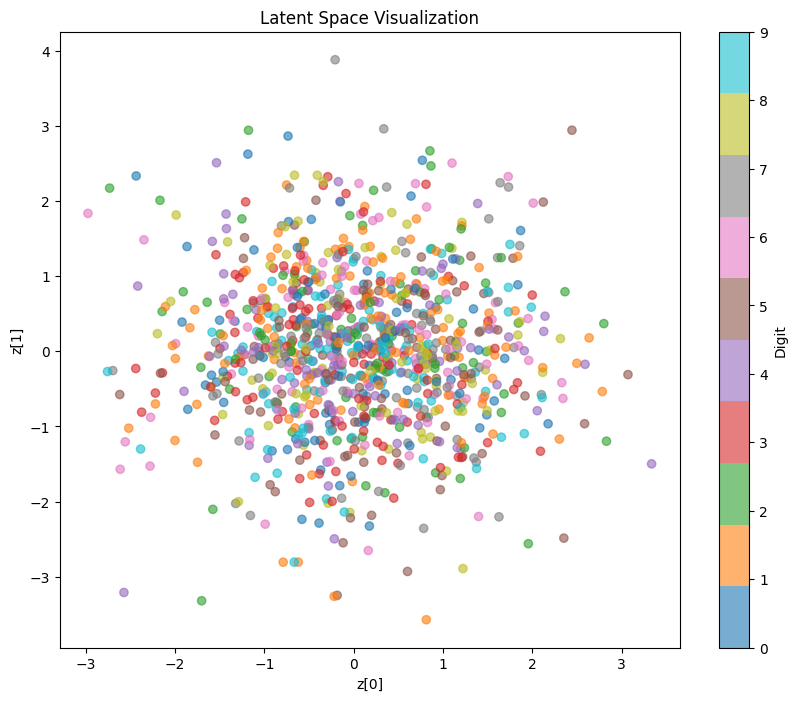

In [22]:
from src.datasets import get_dataloaders

train_loader, test_loader = get_dataloaders(batch_size=128)

# Call the visualization function
visualize_latent_space(
    model=model,
    dataloader=train_loader,  # Assuming test_loader is already defined
    device=device,
    # filepath="latent_space_viz.png",
)

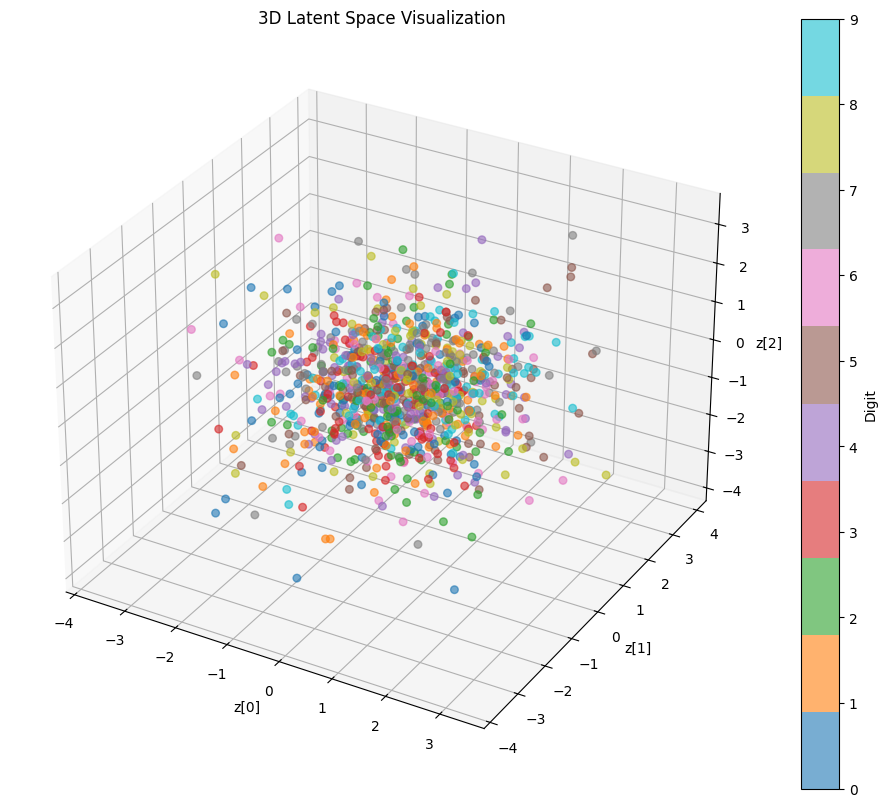

In [ ]:
# Call the visualization function
visualize_latent_space_3d(
    model=model,
    dataloader=train_loader,  # Assuming test_loader is already defined
    device=device,
)

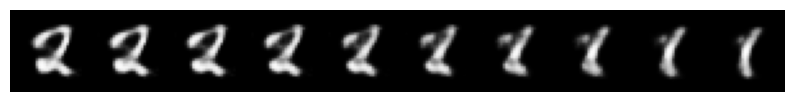

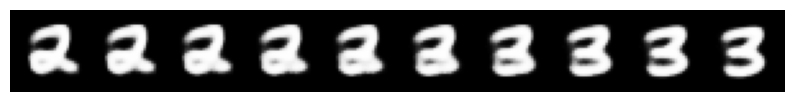

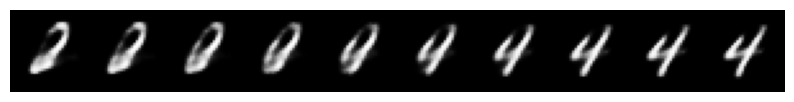

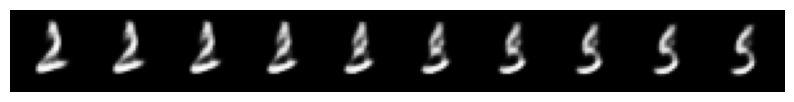

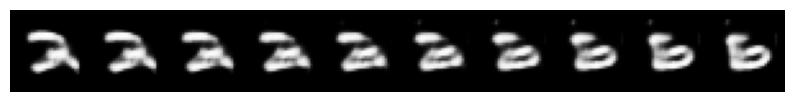

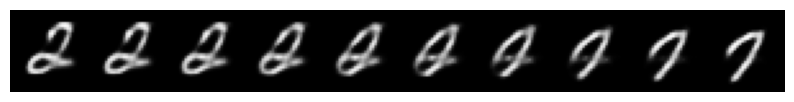

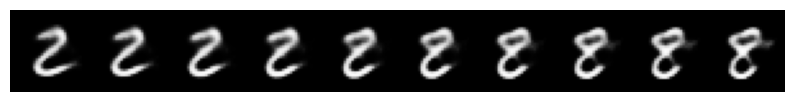

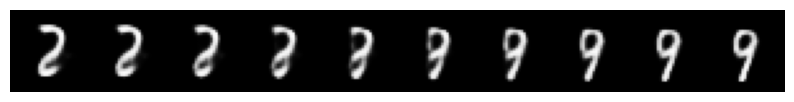

In [ ]:
def interpolate_latent_space(
    model: nn.Module,
    device: torch.device,
    filepath: str,
    start_digit: int = 1,
    end_digit: int = 7,
    steps=10,
    use_conv=False,
):
    model.eval()
    with torch.no_grad():
        # Create conditions for start and end digits
        condition_start = torch.zeros(1, 10)
        condition_start[0, start_digit] = 1.0
        condition_start = condition_start.to(device)

        condition_end = torch.zeros(1, 10)
        condition_end[0, end_digit] = 1.0
        condition_end = condition_end.to(device)

        # Sample from latent space for each digit
        z_start = torch.randn(1, model.latent_dim).to(device)
        z_end = torch.randn(1, model.latent_dim).to(device)

        # Generate interpolated points in latent space
        z_interpolated = torch.zeros(steps, model.latent_dim).to(device)

        for i in range(steps):
            alpha = i / (steps - 1)
            z_interpolated[i] = (1 - alpha) * z_start + alpha * z_end

        # Generate samples for interpolated latent points with fixed condition (start digit)
        samples_z = model.decode(z_interpolated, condition_start.repeat(steps, 1))

        # Generate samples for fixed latent point (start) with interpolated conditions
        condition_interpolated = torch.zeros(steps, 10).to(device)

        for i in range(steps):
            alpha = i / (steps - 1)
            condition_interpolated[i] = (1 - alpha) * condition_start + alpha * condition_end

        samples_c = model.decode(z_start.repeat(steps, 1), condition_interpolated)

        # Reshape for visualization if using non-convolutional model
        if not use_conv:
            samples_z = samples_z.view(-1, 1, 28, 28)
            samples_c = samples_c.view(-1, 1, 28, 28)

        # Save the interpolations
        save_image(samples_c, f"{filepath}_c_interp_{start_digit}to{end_digit}.png", nrow=steps)


start = 2
for i in range(1, 10):
    if i is not start:
        interpolate_latent_space(
            model=model,
            device=device,
            filepath=f"vae_interpolations_{start}_to_{i}",
            start_digit=start,
            end_digit=i,
            steps=10,
            use_conv=False,
        )


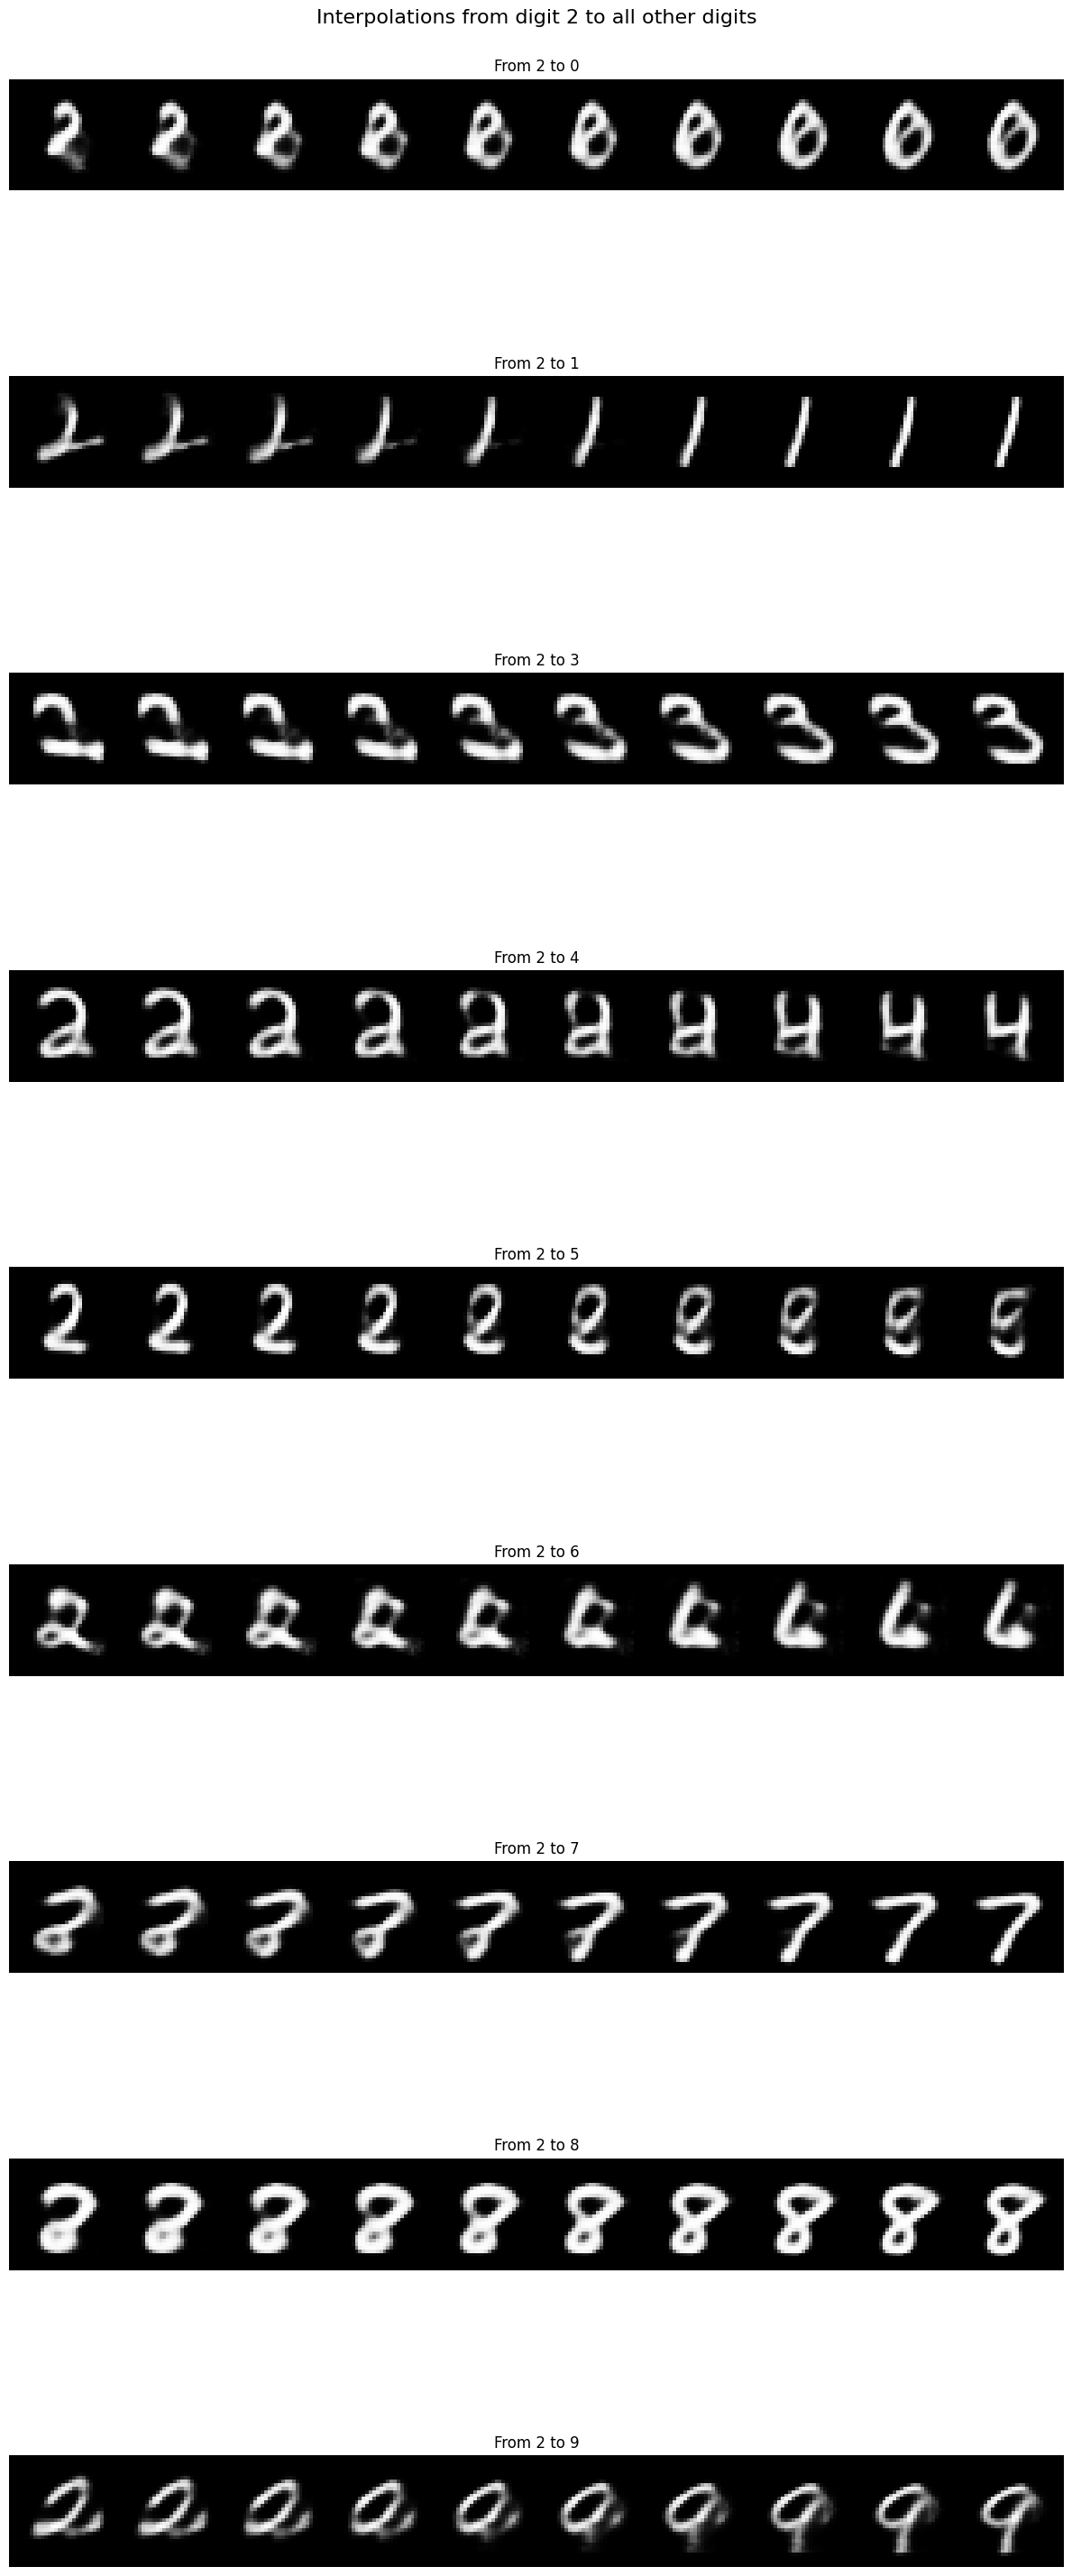

In [ ]:
def save_stacked_interpolations(
    model: nn.Module,
    device: torch.device,
    filepath: str,
    center_digit: int = 5,
    steps: int = 10,
    use_conv: bool = False,
):
    model.eval()
    plt.figure(figsize=(12, 30))

    row_pos = 0

    for target_digit in range(10):
        if target_digit == center_digit:
            continue  # Skip the center/start digit

        with torch.no_grad():
            # Create conditions
            condition_start = torch.zeros(1, 10)
            condition_start[0, center_digit] = 1.0
            condition_start = condition_start.to(device)

            condition_end = torch.zeros(1, 10)
            condition_end[0, target_digit] = 1.0
            condition_end = condition_end.to(device)

            # Use fixed latent vector for consistency
            z_start = torch.randn(1, model.latent_dim).to(device)

            # Generate interpolated conditions
            condition_interpolated = torch.zeros(steps, 10).to(device)
            for i in range(steps):
                alpha = i / (steps - 1)
                condition_interpolated[i] = (1 - alpha) * condition_start + alpha * condition_end

            # Generate samples with interpolated conditions
            samples = model.decode(z_start.repeat(steps, 1), condition_interpolated)

            # Reshape for visualization if using non-convolutional model
            if not use_conv:
                samples = samples.view(-1, 1, 28, 28)

            ax = plt.subplot(9, 1, row_pos + 1)
            row_pos += 1

            grid = make_grid(samples, nrow=steps, padding=2, normalize=True)
            grid_np = grid.cpu().numpy().transpose((1, 2, 0))

            ax.imshow(grid_np)
            ax.set_title(f"From {center_digit} to {target_digit}", fontsize=12)
            ax.axis("off")

    plt.suptitle(f"Interpolations from digit {center_digit} to all other digits", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)  # Reduce space between rows
    plt.savefig(filepath, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()


# Call the function with your model
save_stacked_interpolations(
    model=model,
    device=device,
    filepath="stacked_digit_interpolations.png",
    center_digit=2,
    steps=10,
    use_conv=False,
)